# Fandango ratings data analysis (budget-extended version)

In this project we'll analyze movie ratings data from 2015 and 2016 to determine whether there has been any change in Fandango's rating system after [Hickey's analysis](https://fivethirtyeight.com/features/fandango-movies-ratings/). **This is an extended version of analysis: I've followed a hunch, that money is a very important factor in ratings.** I've gathered additional budget data and analysed its corelation with movie ratings.

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import arange
import bs4
from bs4 import BeautifulSoup
import requests
import urllib
import urllib.request
from urllib.request import urlretrieve 
from urllib.request import urlopen, Request
import re
import time

**Part 1**

The first part doesn't differ much from other notebooks on the matter you can find on the internet. It's a brief and simple attempt at answering the question: Does Fandango still inflate the ratings? It is a good entry point to our analysis in part 2.

**Part 2**

Having done the basic analysis on part 1, I came to conclusion that we need more data! My theory is not groundbreaking but I'will prove it: money is a very important factor in Fandango ratings, not only the amout of money involved in the movie but also where is it coming from. To perform the analysis in part 2, we'll need to aquire more data:
* scrape Wikipedia pages of each movie for budget data and for distribution company data
* analyze the ratings based on the new data

**Links:**
[Datasets](https://github.com/mircealex/Movie_ratings_2016_17) [My Github](https://github.com/grumpyclimber/portfolio) [My LinkedIn](https://www.linkedin.com/in/adam-kubalica-787a79220/)

<a id='index'></a>

Index:
1. Part 1 - comparing Fandango ratings
    * 1.1. [Inital data inspection](#start11)
    * 1.2. [Comparing rating distribution in 2015 and 2016](#comp12)
    * 1.3. [Observations:](#observe)
2. [Part 2](#part2) - further analysis based on data scraped from Wikipedia
    * 2.1. [Preparing for web scraping](#webscrape)
    * 2.2. [Scraping data from Wikipedia](#scrape)
    * 2.3. [Cleaning the new data](#clean)
    * 2.4. [Budget data inital analysis](#budget)
    * 2.5. [Top companies ratings distribution shapes on various platforms](#topshapes)
    * 2.6. [Corelation of company 'size' and their average ratings](#corelate)
    * 2.7. [Fandango ratings distribution for top and other companies](#other)
    * 2.8. [Fandango and Rotten Tomatoes movie ratings vs movie budget](#fanrot)
    * 2.9. [Movie ratings distribution shapes on various platforms per movie budget](#movieb)
    * 2.10. [Top 10 distribution companies: their movies budgets and ratings](#top10)
3. [Conclusions](#conclusion)

<a id='start11'></a>

# 1.1. Inital data inspection

In [2]:
fandango = pd.read_csv('fandango_score.csv')
movies = pd.read_csv('movie_ratings_16_17.csv')
fandango.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [3]:
fandango.columns

Index(['FILM', 'RottenTomatoes', 'RottenTomatoes_User', 'Metacritic',
       'Metacritic_User', 'IMDB', 'Fandango_Stars', 'Fandango_Ratingvalue',
       'RT_norm', 'RT_user_norm', 'Metacritic_norm', 'Metacritic_user_nom',
       'IMDB_norm', 'RT_norm_round', 'RT_user_norm_round',
       'Metacritic_norm_round', 'Metacritic_user_norm_round',
       'IMDB_norm_round', 'Metacritic_user_vote_count', 'IMDB_user_vote_count',
       'Fandango_votes', 'Fandango_Difference'],
      dtype='object')

In [4]:
movies.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


In [5]:
fand = fandango[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes',
                             'Fandango_Difference', 'RT_norm_round', 'RT_user_norm_round',
       'Metacritic_norm_round', 'Metacritic_user_norm_round',
       'IMDB_norm_round', 'Metacritic_user_vote_count', 'IMDB_user_vote_count',
       'Fandango_votes']].copy()

mov = movies[['movie', 'year', 'fandango', 'nr_metascore', 'nr_imdb', 'nr_tmeter', 'nr_audience']].copy()
mov.head()

,movie,year,fandango,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,3.5,4.0,3.5,4.5,4.0
1,13 Hours,2016,4.5,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,3.0,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,4.5,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,3.0,3.0,3.0,3.5,3.0


**Initial observations:**
* small datasets
* various rating sites


**Assigning only 1 year per dataframe**

In [6]:
fand['year'] = fand['FILM'].str[-5:-1].astype(int)
fand['year'].value_counts()

2015    129
2014     17
Name: year, dtype: int64

In [7]:
fand_15 = fand[fand['year']==2015].copy()
fand_15.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,4.5,4.0,3.5,4.0,3.5,249,65709,12640,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,4.0,4.5,3.0,4.0,4.0,627,103660,12055,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,1.0,4.0,1.0,2.5,2.5,31,3136,1793,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,0.5,1.5,1.5,1.5,2.5,88,19560,1021,2015


In [8]:
fand_15.columns

Index(['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes',
       'Fandango_Difference', 'RT_norm_round', 'RT_user_norm_round',
       'Metacritic_norm_round', 'Metacritic_user_norm_round',
       'IMDB_norm_round', 'Metacritic_user_vote_count', 'IMDB_user_vote_count',
       'Fandango_votes', 'year'],
      dtype='object')

In [9]:
mov_16 = mov[mov['year'] == 2016].copy()

In [10]:
fand_15.shape

(129, 14)

In [11]:
mov_16.shape

(191, 7)

<a id='comp12'></a>

# 1.2. Comparing rating distribution in 2015 and 2016

[back to top](#index)

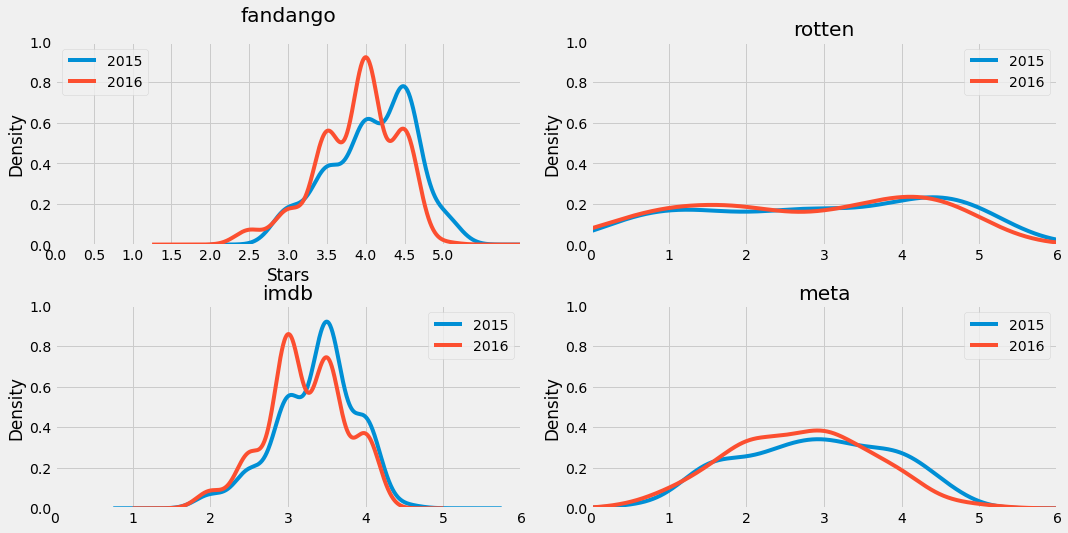

In [12]:
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(2,2,figsize=(16, 14))
ax1 = plt.subplot(221)

fand_15['Fandango_Stars'].plot.kde(label = '2015', legend = True)
mov_16['fandango'].plot.kde(label = '2016', legend = True)
plt.title("fandango",
          y = 1.07) # the `y` parameter pads the title upward
plt.xlabel('Stars')
plt.xlim(0,5) # because ratings start at 0 and end at 5
plt.xticks(arange(0,5.1,.5))
plt.legend(loc=2)
ax2 = plt.subplot(222)
fand_15['RT_norm_round'].plot.kde(label = '2015', legend = True, figsize = (16,8))
mov_16['nr_tmeter'].plot.kde(label = '2016', legend = True)
plt.title('rotten')

ax3 = plt.subplot(223)
fand_15['IMDB_norm_round'].plot.kde(label = '2015', legend = True, figsize = (16,8))
mov_16['nr_imdb'].plot.kde(label = '2016', legend = True)
plt.title('imdb')
ax4 = plt.subplot(224)
fand_15['Metacritic_norm_round'].plot.kde(label = '2015', legend = True, figsize = (16,8))
mov_16['nr_metascore'].plot.kde(label = '2016', legend = True)
plt.title('meta')
axes=[ax1,ax2,ax3,ax4]
for ax in axes:
    ax.set_ylim(0,1)
    ax.set_xlim(0,6)

fig.subplots_adjust(hspace=0.3, wspace=0.15)
plt.show()

In [13]:
mean_15 = fand_15['Fandango_Stars'].mean()
mean_16 = mov_16['fandango'].mean()
median_15 = fand_15['Fandango_Stars'].median()
median_16 = mov_16['fandango'].median()
mode_15 = fand_15['Fandango_Stars'].mode()[0]
mode_16 = mov_16['fandango'].mode()[0]
std_15 = fand_15['Fandango_Stars'].std()
std_16 = mov_16['fandango'].std()

summary = pd.DataFrame()
summary['2015'] = [mean_15, median_15, mode_15, std_15]
summary['2016'] = [mean_16, median_16, mode_16, std_16]
summary['change'] = summary['2016'] - summary['2015']
summary.index = ['mean', 'median', 'mode', 'std']
summary

,2015,2016,change
mean,4.085271,3.887435,-0.197837
median,4.000000,4.000000,0.000000
mode,4.500000,4.000000,-0.500000
std,0.538096,0.509540,-0.028556


In [14]:
mean_15 = fand_15['IMDB_norm_round'].mean()
mean_16 = mov_16['nr_imdb'].mean()
median_15 = fand_15['IMDB_norm_round'].median()
median_16 = mov_16['nr_imdb'].median()
mode_15 = fand_15['IMDB_norm_round'].mode()[0]
mode_16 = mov_16['nr_imdb'].mode()[0]
std_15 = fand_15['IMDB_norm_round'].std()
std_16 = mov_16['nr_imdb'].std()


summary = pd.DataFrame()
summary['2015'] = [mean_15, median_15, mode_15, std_15]
summary['2016'] = [mean_16, median_16, mode_16, std_16]
summary['change'] = summary['2016'] - summary['2015']
summary.index = ['mean', 'median', 'mode', 'std']
summary

,2015,2016,change
mean,3.352713,3.222513,-0.130200
median,3.500000,3.000000,-0.500000
mode,3.500000,3.000000,-0.500000
std,0.505451,0.504157,-0.001294


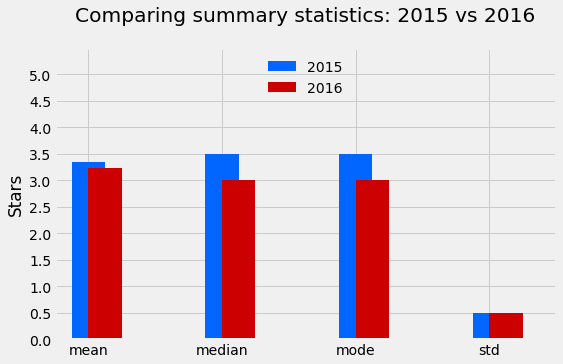

In [15]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

<a id='observe'></a>

# 1.3. Observations:
[back to top](#index)
* Every platform ratings shifted towards less atractive numbers in 2016
    * In cases of Metacritic and Rotten Tomatoes those changes were very small
* Both Fandangos and IMDBs ratings decreased, but Fandango registered a slighly bigger drop in the mean of their ratings 

<a id='part2'></a>

# 2. Part 2 - performing analysis using movies budget data
Having finished the initial analysis, we'll move to the next step. We'll gather more data for every movie. Using BeautifulSoup library we'll scrape Wikipedia for each movies budget data and their distribution company.

<a id='webscrape'></a>

# 2.1. Preparing for web scraping
[back to top](#index)

The process of scraping data from Wikipedia in a few easy steps (longer description is available on [my Github](https://github.com/grumpyclimber/portfolio/tree/main/wiki_scrape)):
* We'll create a column with movie titles edited into a more URL-friendly format (that way we can paste them into the Wikipedias search query url)
* Generate a search query for every title and scrape the results
* Scrape the link of the first result - that is the url of our movie, now we can access every movies Wikipedia page
* Scrape the info-box data of every movie, extract budget (scrape_money function) or distribution company (scrape_distribute2 function)


In [16]:
mov_16['title_urled'] = mov_16['movie'].str.replace('[^A-Za-z0-9]+', '_', regex=True).str.strip('_').str.lower()
mov_16['title_urled'] = mov_16['title_urled'] +'_'+ mov_16['year'].astype(str)
fand_15['title_urled'] = fand_15['FILM'].str.replace('[^A-Za-z0-9]+', '_', regex=True).str.strip('_').str.lower()

In [17]:
def scrape_wiki(df, path_tail='_movie', number_to_add=0):
    # 1. Input:
    search_query = df['title_urled'] + path_tail
    # 2. Put the title into wikipedia search and extract the link to the first result:(it's not the first link!!!)
    url = "https://en.wikipedia.org/w/index.php?search="+search_query+"&title=Special:Search&profile=advanced&fulltext=1&ns0=1"
    html = urlopen(url)
    soup = BeautifulSoup(html, 'lxml')
    web_links = soup.find_all("a")
    # this is the last minute hack, in case there are no search results!!:
    if len(web_links)>43:
        spans = soup.find_all("div", class_="searchresult")
        n = 0
        for el in range(len(spans)):
            if spans[el].text.find('film') != -1:
                n=el
                break
    # 3. the first result of our seach query is actually the eleventh link on the results page: 
    
        movie_path = web_links[10+n+number_to_add].get("href")   
        # 4. now lets scrape all of the infobox-labels into a list a check how long is that list:
        response = requests.get("https://en.wikipedia.org"+movie_path)
        content = response.content
        parser = BeautifulSoup(content, 'html.parser')
        par_len = len(parser.find_all("th", class_="infobox-label"))
        list_of_tags = parser.find_all("th", class_="infobox-label")
        # 5. Loop trough infobox-labels list and find the position of 'Budget':
        for num in range(8,par_len):        
            tag_name = list_of_tags[num]
            if tag_name.text == 'Budget':  
                tag_numbers = parser.find_all("td", class_="infobox-data")[num]
                cash = tag_numbers.text
                break
        # 6. If we can't find the budget:
        else:
            cash = None
        # step 5 for distributor:               
        for num in range(4,par_len):        
            tag_name = list_of_tags[num]
            if tag_name.text == 'Distributed by':  
                tag_numbers = parser.find_all("td", class_="infobox-data")[num]
                distributor = tag_numbers.text
                break
        # 6.1. If we can't find the distributor:
        else:
            distributor = None
        return cash, distributor

<a id='scrape'></a>

# 2.2. Scraping data from Wikipedia
[back to top](#index)

In [18]:
fand_15['data'] = fand_15.apply(scrape_wiki, axis=1)
time.sleep(np.random.randint(1,19))
fand_15.loc[fand_15['data'].str[0].isnull(), 'data'] = fand_15[fand_15['data'].str[0].isnull()].apply(scrape_wiki, axis=1,args=('',0))
time.sleep(np.random.randint(1,19))

mov_16['data'] = mov_16.apply(scrape_wiki, axis=1)
time.sleep(np.random.randint(1,19))
mov_16.loc[mov_16['data'].str[0].isnull(), 'data'] = mov_16[mov_16['data'].str[0].isnull()].apply(scrape_wiki, axis=1,args=('',0))

In [19]:
fand_15['budget'] = fand_15['data'].str[0]
mov_16['budget'] = mov_16['data'].str[0]
fand_15['distributor'] = fand_15['data'].str[1]
mov_16['distributor'] = mov_16['data'].str[1]

In [20]:
mov_16.head()

,movie,year,fandango,nr_metascore,nr_imdb,nr_tmeter,nr_audience,title_urled,data,budget,distributor
0,10 Cloverfield Lane,2016,3.5,4.0,3.5,4.5,4.0,10_cloverfield_lane_2016,"($13–15 million[2][3][4], Paramount Pictures)",$13–15 million[2][3][4],Paramount Pictures
1,13 Hours,2016,4.5,2.5,3.5,2.5,4.0,13_hours_2016,"($50 million[2], Paramount Pictures)",$50 million[2],Paramount Pictures
2,A Cure for Wellness,2016,3.0,2.5,3.5,2.0,2.5,a_cure_for_wellness_2016,"($40 million[2], 20th Century Fox)",$40 million[2],20th Century Fox
4,A Hologram for the King,2016,3.0,3.0,3.0,3.5,3.0,a_hologram_for_the_king_2016,"($35 million[4][5], \nLionsgate\nRoadside Attr...",$35 million[4][5],\nLionsgate\nRoadside Attractions\nSaban Films...
5,A Monster Calls,2016,4.0,4.0,4.0,4.5,4.0,a_monster_calls_2016,"($43 million[4], \nUniversal Pictures (Spain)\...",$43 million[4],\nUniversal Pictures (Spain)\nEntertainment On...


In [21]:
fand_15.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,year,title_urled,data,budget,distributor
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,2015,avengers_age_of_ultron_2015,(\n$444–495.2 million (gross)[2][3]\n$365 mill...,\n$444–495.2 million (gross)[2][3]\n$365 milli...,Walt Disney StudiosMotion Pictures
1,Cinderella (2015),5.0,4.5,12640,0.5,4.5,4.0,3.5,4.0,3.5,249,65709,12640,2015,cinderella_2015,"($84.21-95 million[5][6], Walt Disney StudiosM...",$84.21-95 million[5][6],Walt Disney StudiosMotion Pictures
2,Ant-Man (2015),5.0,4.5,12055,0.5,4.0,4.5,3.0,4.0,4.0,627,103660,12055,2015,ant_man_2015,"($130–169.3 million[2][3][4], Walt Disney Stud...",$130–169.3 million[2][3][4],Walt Disney StudiosMotion Pictures
3,Do You Believe? (2015),5.0,4.5,1793,0.5,1.0,4.0,1.0,2.5,2.5,31,3136,1793,2015,do_you_believe_2015,"($2.3 million[2], Pure Flix Entertainment)",$2.3 million[2],Pure Flix Entertainment
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,0.5,1.5,1.5,1.5,2.5,88,19560,1021,2015,hot_tub_time_machine_2_2015,"($14–18 million[4][5], Paramount Pictures[1][2])",$14–18 million[4][5],Paramount Pictures[1][2]


In [22]:
fand_15[fand_15['budget'].isnull()].shape[0] / fand_15.shape[0]

0.13178294573643412

In [23]:
mov_16[mov_16['budget'].isnull()].shape[0] / mov_16.shape[0]

0.1099476439790576

<a id='clean'></a>

# 2.3. Cleaning the new data
[back to top](#index)

The budget data very often comes in a range format, rather than a single number. We'll choose the lower number and store it in the 'low_end' column. 

In [24]:
# regex magic to clean the budget data: 
fand_15['low_end'] =  fand_15['budget'].str.extract("[$£€¥](\d+[.]?[\d+]?)").astype(float)
fand_15['is_it_mill'] = fand_15['budget'].str.contains("million")
fand_15['currency'] = fand_15['budget'].str.extract("([$£€¥])")
fand_15.loc[fand_15['is_it_mill'] == False, 'low_end'] = 0.1
fand_15['distributor'] = fand_15['distributor'].str.extract("([A-Z,0-9]\w+[\s]?\w+)")

# regex magic to clean the budget data: 
mov_16['low_end'] =  mov_16['budget'].str.extract("[$£€¥](\d+[.]?[\d+]?)").astype(float)
mov_16['is_it_mill'] = mov_16['budget'].str.contains("million")
mov_16['currency'] = mov_16['budget'].str.extract("([$£€¥])")
mov_16.loc[mov_16['is_it_mill'] == False, 'low_end'] = mov_16.loc[mov_16['is_it_mill'] == False, 'low_end'] / 1000
mov_16['distributor'] = mov_16['distributor'].str.extract("([A-Z,0-9]\w+[\s]?\w+)")

**To make life easier: we'll be using short versions of each companies name** (eg. Walt Disney instead of Walt Disney Motion Pictures).

In [25]:
mov_16.head()

,movie,year,fandango,nr_metascore,nr_imdb,nr_tmeter,nr_audience,title_urled,data,budget,distributor,low_end,is_it_mill,currency
0,10 Cloverfield Lane,2016,3.5,4.0,3.5,4.5,4.0,10_cloverfield_lane_2016,"($13–15 million[2][3][4], Paramount Pictures)",$13–15 million[2][3][4],Paramount Pictures,13.0,True,$
1,13 Hours,2016,4.5,2.5,3.5,2.5,4.0,13_hours_2016,"($50 million[2], Paramount Pictures)",$50 million[2],Paramount Pictures,50.0,True,$
2,A Cure for Wellness,2016,3.0,2.5,3.5,2.0,2.5,a_cure_for_wellness_2016,"($40 million[2], 20th Century Fox)",$40 million[2],20th Century,40.0,True,$
4,A Hologram for the King,2016,3.0,3.0,3.0,3.5,3.0,a_hologram_for_the_king_2016,"($35 million[4][5], \nLionsgate\nRoadside Attr...",$35 million[4][5],Lionsgate\nRoadside,35.0,True,$
5,A Monster Calls,2016,4.0,4.0,4.0,4.5,4.0,a_monster_calls_2016,"($43 million[4], \nUniversal Pictures (Spain)\...",$43 million[4],Universal Pictures,43.0,True,$


In [26]:
fand_15.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,...,IMDB_user_vote_count,Fandango_votes,year,title_urled,data,budget,distributor,low_end,is_it_mill,currency
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,3.5,4.5,3.5,3.5,4.0,...,271107,14846,2015,avengers_age_of_ultron_2015,(\n$444–495.2 million (gross)[2][3]\n$365 mill...,\n$444–495.2 million (gross)[2][3]\n$365 milli...,Walt Disney,444.0,True,$
1,Cinderella (2015),5.0,4.5,12640,0.5,4.5,4.0,3.5,4.0,3.5,...,65709,12640,2015,cinderella_2015,"($84.21-95 million[5][6], Walt Disney StudiosM...",$84.21-95 million[5][6],Walt Disney,84.2,True,$
2,Ant-Man (2015),5.0,4.5,12055,0.5,4.0,4.5,3.0,4.0,4.0,...,103660,12055,2015,ant_man_2015,"($130–169.3 million[2][3][4], Walt Disney Stud...",$130–169.3 million[2][3][4],Walt Disney,130.0,True,$
3,Do You Believe? (2015),5.0,4.5,1793,0.5,1.0,4.0,1.0,2.5,2.5,...,3136,1793,2015,do_you_believe_2015,"($2.3 million[2], Pure Flix Entertainment)",$2.3 million[2],Pure Flix,2.3,True,$
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,0.5,1.5,1.5,1.5,2.5,...,19560,1021,2015,hot_tub_time_machine_2_2015,"($14–18 million[4][5], Paramount Pictures[1][2])",$14–18 million[4][5],Paramount Pictures,14.0,True,$


In [27]:
fand_15 = fand_15.drop(columns=['year','title_urled' ,'budget', 'data'])
mov_16 = mov_16.drop(columns=['year','title_urled' ,'budget', 'data'])
fand_15 = fand_15.loc[:,~fand_15.columns.duplicated()].copy()

# Currency:
GBP: Average exchange rate in 2015: 1.5285 USD

EUR Average exchange rate in 2015: 1.11 USD

In [28]:
fand_15.loc[fand_15['currency'] == '£', 'low_end'] = fand_15['low_end'] * 1.5
fand_15.loc[fand_15['currency'] == '£', 'currency'] = '$'
fand_15.loc[fand_15['currency'] == '€', 'low_end'] = fand_15['low_end'] * 1.1
fand_15.loc[fand_15['currency'] == '€', 'currency'] = '$'
fand_15.loc[fand_15['currency'] == '¥', 'low_end'] = 10.5
fand_15.loc[fand_15['currency'] == '¥', 'currency'] = '$'

<a id='budget'></a>

# 2.4. Budget data inital analysis
[back to top](#index)

In [29]:
fand_15.groupby('distributor')['low_end'].sum().sum()

5069.08

In [30]:
mov_16.groupby('distributor')['low_end'].sum().sum()

8761.2

In [31]:
df_size_diff = (mov_16.shape[0] - fand_15.shape[0]) / fand_15.shape[0]
print('The 2016 dataset is ',round(df_size_diff * 100,2),' % bigger (more entries).')

The 2016 dataset is  48.06  % bigger (more entries).


In [32]:
avg_budget_growth = ( mov_16['low_end'].mean() - fand_15['low_end'].mean() ) /  fand_15['low_end'].mean()
print('The 2016 movie budget mean is ',round(avg_budget_growth *100,2),' % bigger than 2015.')

The 2016 movie budget mean is  13.87  % bigger than 2015.


In [33]:
median_budget_growth = ( mov_16['low_end'].median() - fand_15['low_end'].median() ) /  fand_15['low_end'].median()
print('The 2016 movie budget  median is ',round(median_budget_growth *100,2),' % bigger than 2015.')

The 2016 movie budget  median is  26.09  % bigger than 2015.


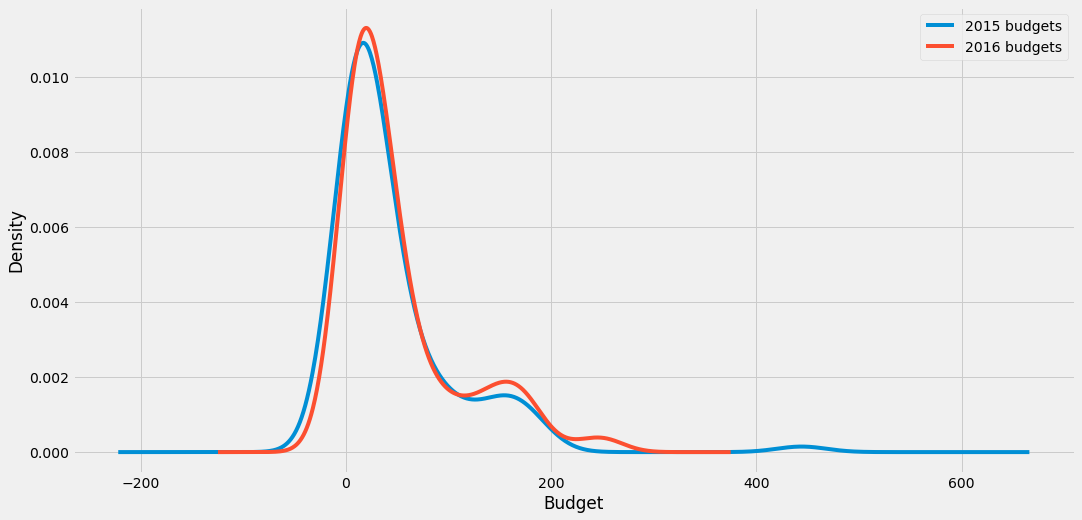

In [34]:
fig, axes = plt.subplots(figsize=(16, 8))
fand_15['low_end'].plot.kde(label = '2015 budgets', legend = True)
mov_16['low_end'].plot.kde(label = '2016 budgets', legend = True)
plt.xlabel('Budget')
plt.show()

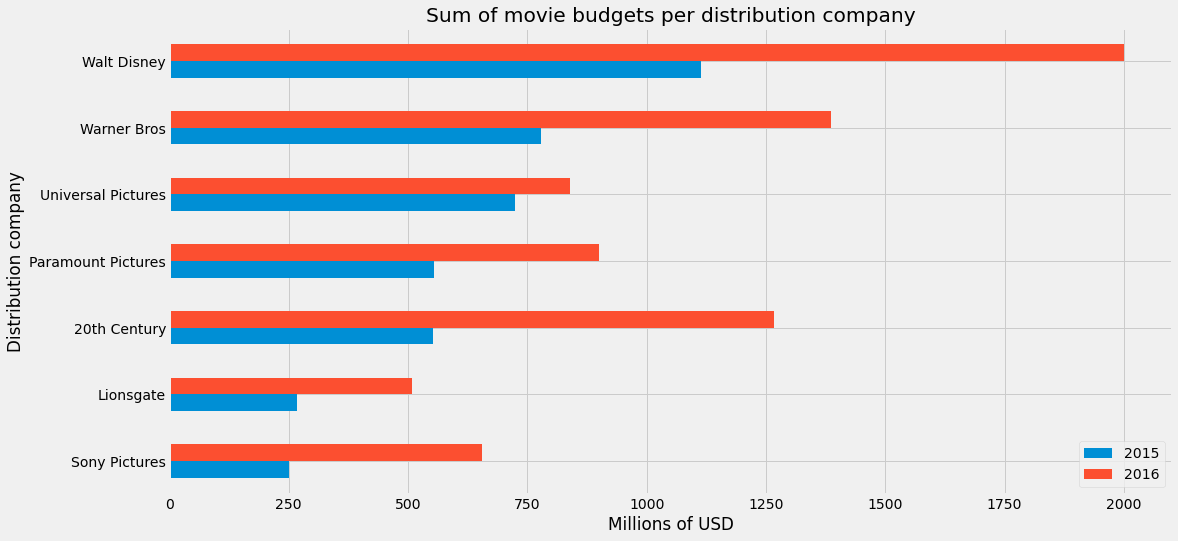

In [35]:
top10_in16 = mov_16.groupby('distributor')['low_end'].sum().sort_values(ascending=False)[:10].to_frame()
top10_in15 = fand_15.groupby('distributor')['low_end'].sum().sort_values(ascending=False)[:10].to_frame()
top10_both = top10_in15.merge(top10_in16, left_index=True, right_index=True)
top10_both.columns=['2015','2016']
top10_both = top10_both.sort_values('2015')

top10_both.plot.barh(label = '2015 vs 2016', legend = True, figsize=(16,8))
plt.title('Sum of movie budgets per distribution company')
plt.xlabel('Millions of USD')
plt.ylabel('Distribution company')
plt.show()

# Budget data inital observations:
* Our dataset with 2016 movies is bigger than our 2015 dataset - that should not be a big issue, but we must always remember that fact
* **Movies from 2016 tend to have a bigger budget**
    * The 2016 movie budget mean is  13.87  % bigger than 2015
    * The 2016 movie budget  median is  26.09  % bigger than 2015
* Although these metrics may be worrying and stop us from performing certain precise analysis, the Kernel density plot presents that overall the distribution of movie budgets hasn't changed that much between our two dataframes.


<a id='topshapes'></a>

# 2.5. Top companies ratings distribution shapes on various platforms
[back to top](#index)

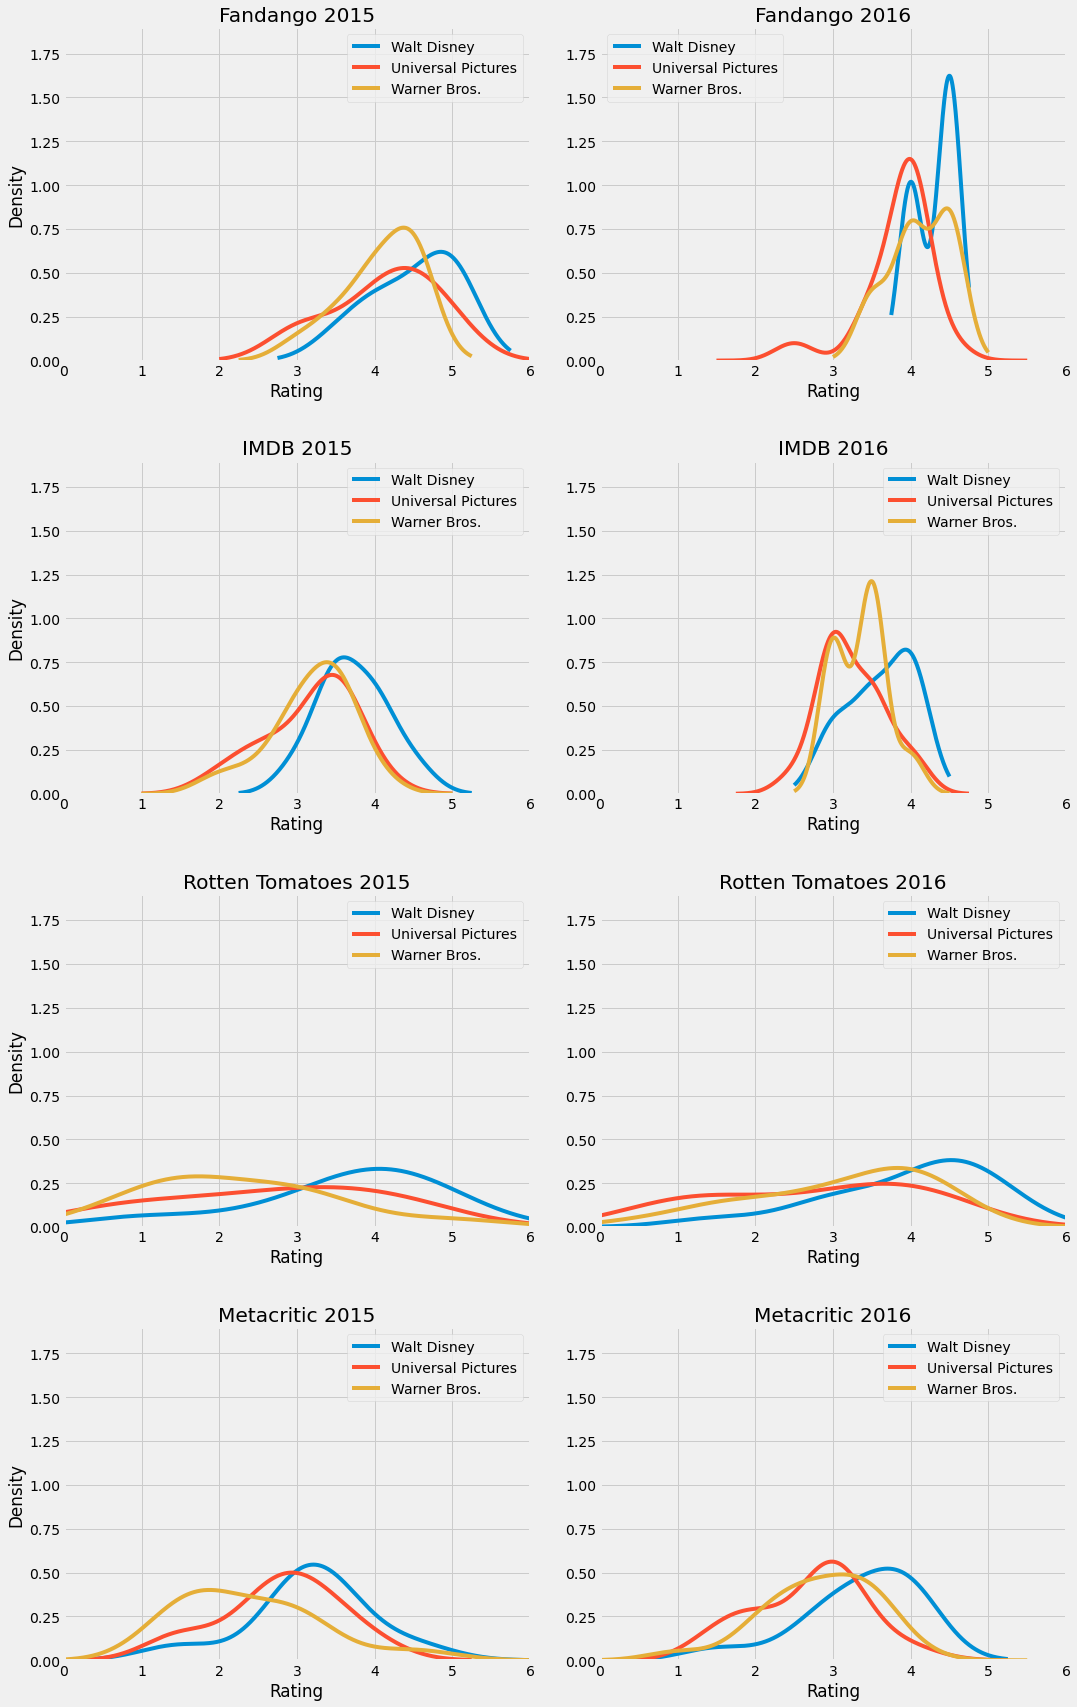

In [36]:
waltdf15 = fand_15[fand_15['distributor']=='Walt Disney']
univ15 = fand_15[fand_15['distributor']=='Universal Pictures']
warner15 = fand_15[fand_15['distributor']=='Warner Bros']
waltdf16 = mov_16[mov_16['distributor']=='Walt Disney']
univ16 = mov_16[mov_16['distributor']=='Universal Pictures']
warner16 = mov_16[mov_16['distributor']=='Warner Bros']

plt.style.use('fivethirtyeight')
def three_plots_15(col_name):
    x1 = waltdf15[col_name].plot.kde(label = 'Walt Disney', legend = True)
    x2 = univ15[col_name].plot.kde(label = 'Universal Pictures', legend = True)
    x3 = warner15[col_name].plot.kde(label = 'Warner Bros.', legend = True)
    return x1, x2, x3
def three_plots_16(col_name):
    x1 = waltdf16[col_name].plot.kde(label = 'Walt Disney', legend = True)
    x2 = univ16[col_name].plot.kde(label = 'Universal Pictures', legend = True)
    x3 = warner16[col_name].plot.kde(label = 'Warner Bros.', legend = True)
    return x1, x2, x3

fig, axes = plt.subplots(2,2,figsize=(16, 28))
fig.subplots_adjust(hspace=0.3, wspace=0.15)
ax1 = plt.subplot(421)
three_plots_15('Fandango_Stars')
ax2 = plt.subplot(422)
three_plots_16('fandango')
ax3 = plt.subplot(423)
three_plots_15('IMDB_norm_round')
ax4 = plt.subplot(424)
three_plots_16('nr_imdb')
ax5 = plt.subplot(425)
three_plots_15('RT_norm_round')
ax6 = plt.subplot(426)
three_plots_16('nr_tmeter')
ax7 = plt.subplot(427)
three_plots_15('Metacritic_norm_round')
ax8 = plt.subplot(428)
three_plots_16('nr_metascore')
titles = ['Fandango 2015', 'Fandango 2016','IMDB 2015', 'IMDB 2016', 'Rotten Tomatoes 2015', 
          'Rotten Tomatoes 2016', 'Metacritic 2015', 'Metacritic 2016']
axes=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
for n in list(range(0,8)):
    axes[n].set_ylim(0,1.9)
    axes[n].set_xlim(0,6)
    axes[n].set_title(titles[n])
    axes[n].set_xlabel('Rating')
right_axes=[ax2,ax4,ax6,ax8]  
for ax in right_axes:
    ax.set_ylabel('',visible=False)

plt.show()

**Observations:**
* Walt Disney, being the top distributor tends to have the best average ratings on Fandango and other platforms
    * We can notice that Disney ratings are shifting further right - away from other distributors in 2016
* Fandango ratings in 2016 dropped, even major distribution companies like Disney were not spared.
* Interesting finding is that the movie ratings of major distribution companies in 2016 became more concentrated on both Fandango and IMDB platforms
* Rotten Tomatoes have the most uniform ratings distribution, followed by Metacritic

<a id='corelate'></a>

# 2.6. Corelation of company 'size' and their average ratings
[back to top](#index)

For the purpose of further analysis plot, we'll group distributors based on their movies budget data:
* we'll group the dataframes by distributors and count the sum of their movies budgets (combining movies budgets for every distributor)
* we'll sort the distributors by their combined movie budgets and select top 10 (we'll name them top)
* the remaining distributors we'll be called 'rest' (or other)

In [37]:
top10_in16 = mov_16.groupby('distributor')['low_end'].sum().sort_values(ascending=False)[:10].to_frame()
stars_16 = mov_16[mov_16['distributor'].isin(top10_in16.index.tolist())].groupby('distributor')['fandango'].mean().sort_values(ascending=False).to_frame()
budget_16 = mov_16[mov_16['distributor'].isin(top10_in16.index.tolist())].groupby('distributor')['low_end'].sum().sort_values(ascending=False).to_frame()
both_16 = stars_16.merge(budget_16, left_index=True, right_index=True)
stars_16t = mov_16[mov_16['distributor'].isin(top10_in16.index.tolist())].groupby('distributor')['nr_tmeter'].mean().sort_values(ascending=False).to_frame()
budget_16t = mov_16[mov_16['distributor'].isin(top10_in16.index.tolist())].groupby('distributor')['low_end'].sum().sort_values(ascending=False).to_frame()
both_16t = stars_16t.merge(budget_16t, left_index=True, right_index=True)

both_both = both_16.merge(both_16t, left_index=True, right_index=True)
both_both = both_both.drop(columns=both_both.columns[-3])
both_both.columns=['Fandango 2016', 'Rotten 2016', '2016 movies budget sum']
both_both.sort_values(both_both.columns[-1], ascending = False)

,Fandango 2016,Rotten 2016,2016 movies budget sum
distributor,,,
Walt Disney,4.307692,3.961538,2000.0
Warner Bros,4.119048,3.095238,1385.9
20th Century,3.970588,2.647059,1266.0
Paramount Pictures,3.750000,2.857143,900.0
Universal Pictures,3.843750,2.750000,840.0
Sony Pictures,4.000000,2.500000,654.3
Lionsgate,3.966667,2.533333,508.0
Summit Entertainment,3.500000,1.750000,157.0
China Film,4.000000,2.000000,150.0


**Observations:**
* Looking at top distributors and their movies average ratings in 2016 we can see a small correlation between the size of the distributor (the sum of their movies budgets) and average Fandango ratings for the distributor
* This corelations is not unique for Fandango, we can see the same pattern in Rotten Tomatoes - the platform with the most uniform distribution of ratings! Though we have to mention: the ratings are much lower on Rotten Tomatoes.

<a id='other'></a>

# 2.7. Fandango ratings distribution for top and other companies
[back to top](#index)

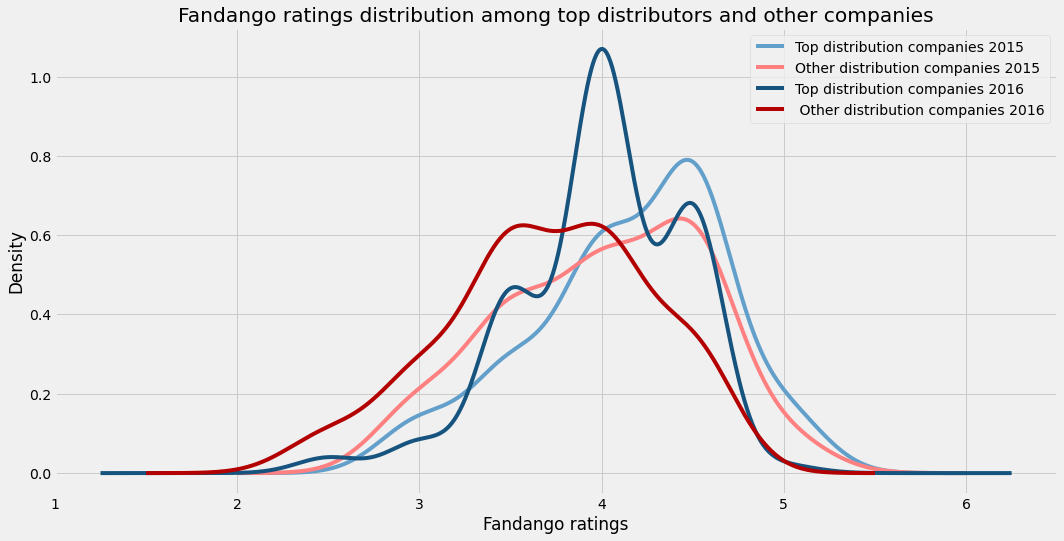

In [38]:
stars_15top = fand_15[fand_15['distributor'].isin(top10_in15.index.tolist())]
stars_15rest = fand_15[~fand_15['distributor'].isin(top10_in15.index.tolist())]
stars_16top = mov_16[mov_16['distributor'].isin(top10_in16.index.tolist())]
stars_16rest = mov_16[~mov_16['distributor'].isin(top10_in16.index.tolist())]

fig, axes = plt.subplots(figsize=(16, 8))
stars_15top['Fandango_Stars'].plot.kde(label = '2015 top', legend = True, c='#62a0cb')
stars_15rest['Fandango_Stars'].plot.kde(label = '2015 rest', legend = True,c ='#ff8080')
stars_16top['fandango'].plot.kde(label = '2016 top', legend = True, c='#16537e')
stars_16rest['fandango'].plot.kde(label = '2016 rest', legend = True,c ='#b30000' )

stars_15top['Fandango_Stars'].mean()
stars_15rest['Fandango_Stars'].mean()
plt.title('Fandango ratings distribution among top distributors and other companies')
plt.legend(labels=['Top distribution companies 2015','Other distribution companies 2015',
                   'Top distribution companies 2016',' Other distribution companies 2016'])
plt.xlabel('Fandango ratings')
plt.show()

**Observations:**
* Fandango ratings in 2015 had a very similar distribution for both major distribution companies and smaller companies
* Unsurprisingly we can observe a drop in ratings in 2016, but the change is bigger among movies not distributed by the top companies
    * **Ratings distribution of top distributors and the rest is not so similar anymore in 2016**

<a id='fanrot'></a>

# 2.8. Fandango and Rotten Tomatoes movie ratings vs movie budget
[back to top](#index)

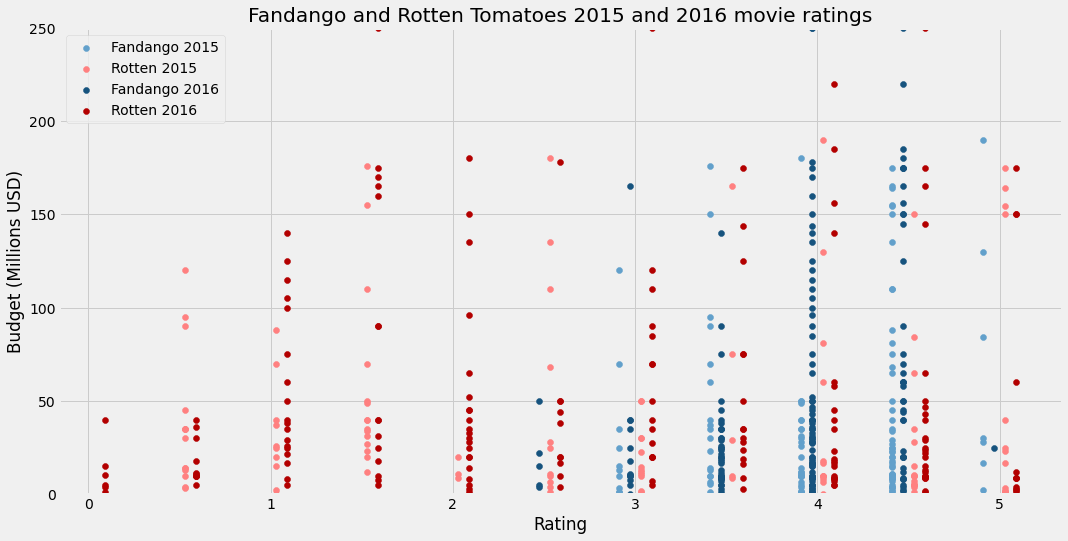

In [39]:
fig, ax = plt.subplots(figsize=(16,8))
fand_15['forplot1'] = fand_15['Fandango_Stars'] - 0.09
mov_16['forplot1'] = mov_16['fandango'] - 0.03
fand_15['forplot2'] = fand_15['RT_norm_round'] + 0.03
mov_16['forplot2'] = mov_16['nr_tmeter'] + 0.09

plt.scatter(data=fand_15, y='low_end', x='forplot1', label='Fandango 2015', c='#62a0cb')
plt.scatter(data=fand_15, y='low_end', x='forplot2', label='Rotten 2015' ,c ='#ff8080')
plt.scatter(data=mov_16, y='low_end', x='forplot1', label='Fandango 2016', c='#16537e')
plt.scatter(data=mov_16, y='low_end', x='forplot2', label='Rotten 2016',c ='#b30000' )

plt.ylim(0,250)
plt.ylabel('Budget (Millions USD)')
plt.xlabel('Rating')
plt.legend(loc=2)
plt.title('Fandango and Rotten Tomatoes 2015 and 2016 movie ratings')
fand_15 = fand_15.drop(['forplot1', 'forplot2'], axis=1)
mov_16 = mov_16.drop(['forplot1', 'forplot2'], axis=1)
plt.show()

<a id='movieb'></a>

# 2.9. Movie ratings distribution shapes on various platforms per movie budget
[back to top](#index)

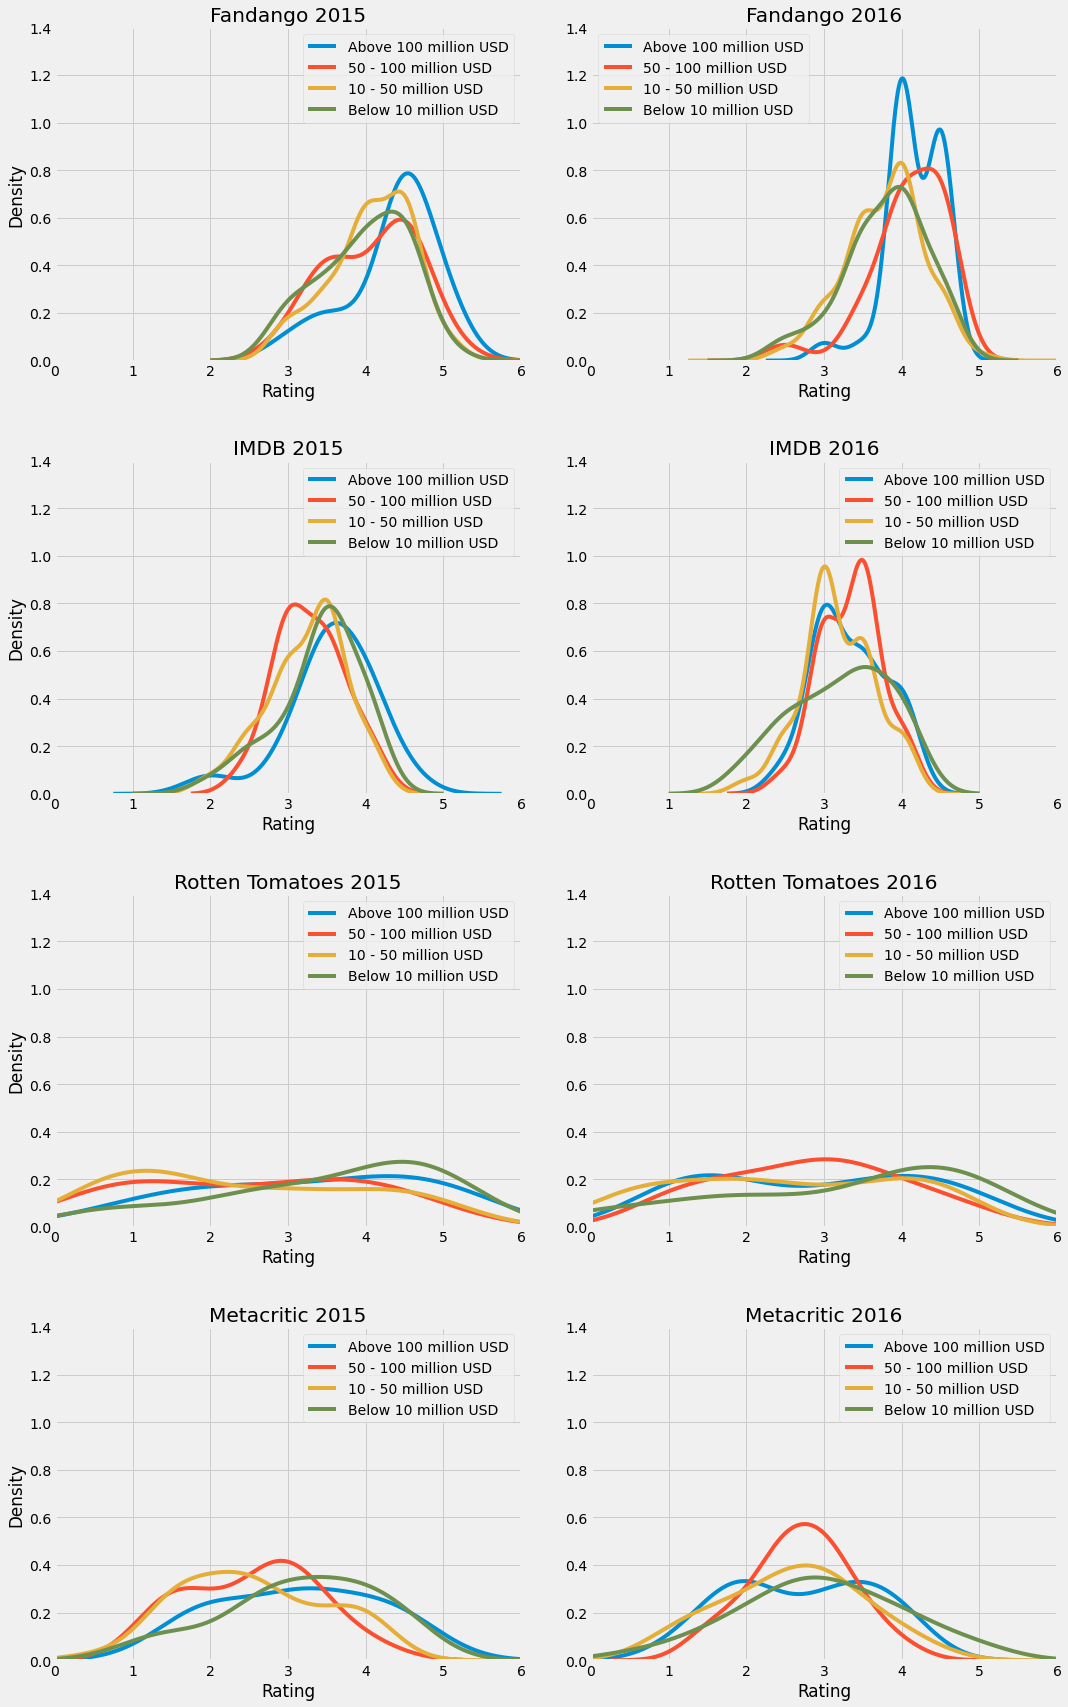

In [40]:
fand_15_100 = fand_15[fand_15['low_end']>=100]
fand_15_50 = fand_15[(fand_15['low_end']>=50) & (fand_15['low_end']<100)]
fand_15_10 = fand_15[(fand_15['low_end']>=10) & (fand_15['low_end']<50)]
fand_15_0 = fand_15[fand_15['low_end']<10]

mov16_100 = mov_16[mov_16['low_end']>=100]
mov16_50 = mov_16[(mov_16['low_end']>=50) & (mov_16['low_end']<100)]
mov16_10 = mov_16[(mov_16['low_end']>=10) & (mov_16['low_end']<50)]
mov16_0 = mov_16[mov_16['low_end']<10]

plt.style.use('fivethirtyeight')
def four_plots_15(col_name):
    x1 = fand_15_100[col_name].plot.kde(label = 'Above 100 million USD', legend = True)
    x2 = fand_15_50[col_name].plot.kde(label = '50 - 100 million USD', legend = True)
    x3 = fand_15_10[col_name].plot.kde(label = '10 - 50 million USD', legend = True)
    x4 = fand_15_0[col_name].plot.kde(label = 'Below 10 million USD', legend = True)
    return x1, x2, x3, x4
def four_plots_16(col_name):
    x1 = mov16_100[col_name].plot.kde(label = 'Above 100 million USD', legend = True)
    x2 = mov16_50[col_name].plot.kde(label = '50 - 100 million USD', legend = True)
    x3 = mov16_10[col_name].plot.kde(label = '10 - 50 million USD', legend = True)
    x4 = mov16_0[col_name].plot.kde(label = 'Below 10 million USD', legend = True)
    return x1, x2, x3, x4

fig, axes = plt.subplots(2,2,figsize=(16, 28))
fig.subplots_adjust(hspace=0.3, wspace=0.15)
ax1 = plt.subplot(421)
four_plots_15('Fandango_Stars')
ax2 = plt.subplot(422)
four_plots_16('fandango')
ax3 = plt.subplot(423)
four_plots_15('IMDB_norm_round')
ax4 = plt.subplot(424)
four_plots_16('nr_imdb')
ax5 = plt.subplot(425)
four_plots_15('RT_norm_round')
ax6 = plt.subplot(426)
four_plots_16('nr_tmeter')
ax7 = plt.subplot(427)
four_plots_15('Metacritic_norm_round')
ax8 = plt.subplot(428)
four_plots_16('nr_metascore')
titles = ['Fandango 2015', 'Fandango 2016','IMDB 2015', 'IMDB 2016', 'Rotten Tomatoes 2015', 
          'Rotten Tomatoes 2016', 'Metacritic 2015', 'Metacritic 2016']
axes=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
for n in list(range(0,8)):
    axes[n].set_ylim(0,1.4)
    axes[n].set_xlim(0,6)
    axes[n].set_title(titles[n])
    axes[n].set_xlabel('Rating')

right_axes=[ax2,ax4,ax6,ax8]  
for ax in right_axes:
    ax.set_ylabel('',visible=False)

plt.show()

Grouping the movies by their budgets hasn't presented us with any revolutionary findings:
* We can observe that in 2016 the distribution on Fandango website is becoming more concentrated, especially for movies with budgets above 100 million USD
* Movies with budgets between 50-100 million USD registered concentration of their frequency distribution on every platfrom

<a id='top10'></a>

# 2.10. Top 10 distribution companies: their movies budgets and ratings
[back to top](#index)

In the below plots, we'll display the sum of movies budgets data per distribution company and rating, each points size represents sum of all the movies budgets for that rating and distributor.

In [41]:
di16 = top10_in16.index.tolist()
di15 = top10_in15.index.tolist()
di_ratings16 = mov_16[mov_16['distributor'].isin(di16)].groupby('distributor')['fandango'].mean().sort_values(ascending=False).to_frame()
di_budget16 = mov_16[mov_16['distributor'].isin(di16)].groupby('distributor')['low_end'].sum().sort_values(ascending=False).to_frame()
budget_rating16 = di_ratings16.merge(di_budget16, left_index=True, right_index=True)
di_budget15 = fand_15[fand_15['distributor'].isin(di16)].groupby('distributor')['low_end'].sum().sort_values(ascending=False).to_frame()
di_ratings15 = fand_15[fand_15['distributor'].isin(di16)].groupby('distributor')['Fandango_Stars'].mean().sort_values(ascending=False).to_frame()
budget_rating15 = di_ratings15.merge(di_budget15, left_index=True, right_index=True)
m16_topdi = mov_16[mov_16['distributor'].isin(di16)]
f15_topdi = fand_15[fand_15['distributor'].isin(di15)]

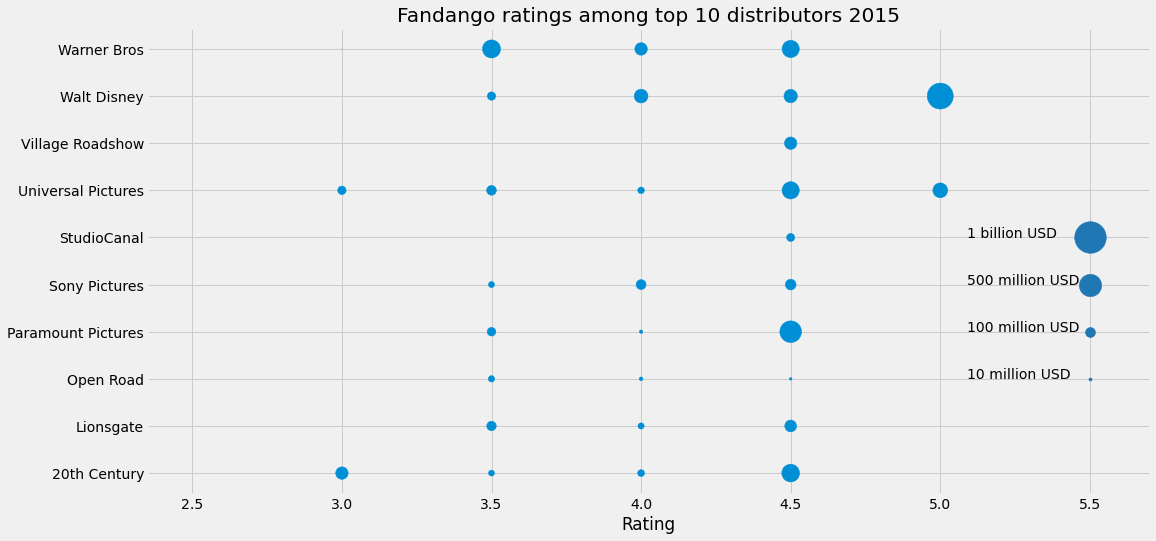

In [42]:
df_counts = f15_topdi.groupby(['distributor', 'Fandango_Stars'])['low_end'].sum().reset_index(name='low_end')
fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(data=df_counts, y='distributor', x='Fandango_Stars', s='low_end')
plt.scatter(x=5.5, y=2, s=10, c='#1f77b4')
plt.scatter(x=5.5, y=3, s=100, c='#1f77b4')
plt.scatter(x=5.5, y=4, s=500, c='#1f77b4')
plt.scatter(x=5.5, y=5, s=1000, c='#1f77b4')
plt.text(5.09,2, '10 million USD')
plt.text(5.09,3, '100 million USD')
plt.text(5.09,4, '500 million USD')
plt.text(5.09,5, '1 billion USD')
plt.title('Fandango ratings among top 10 distributors 2015')
plt.xlim(2.35,5.7)
plt.xlabel('Rating')
plt.show()

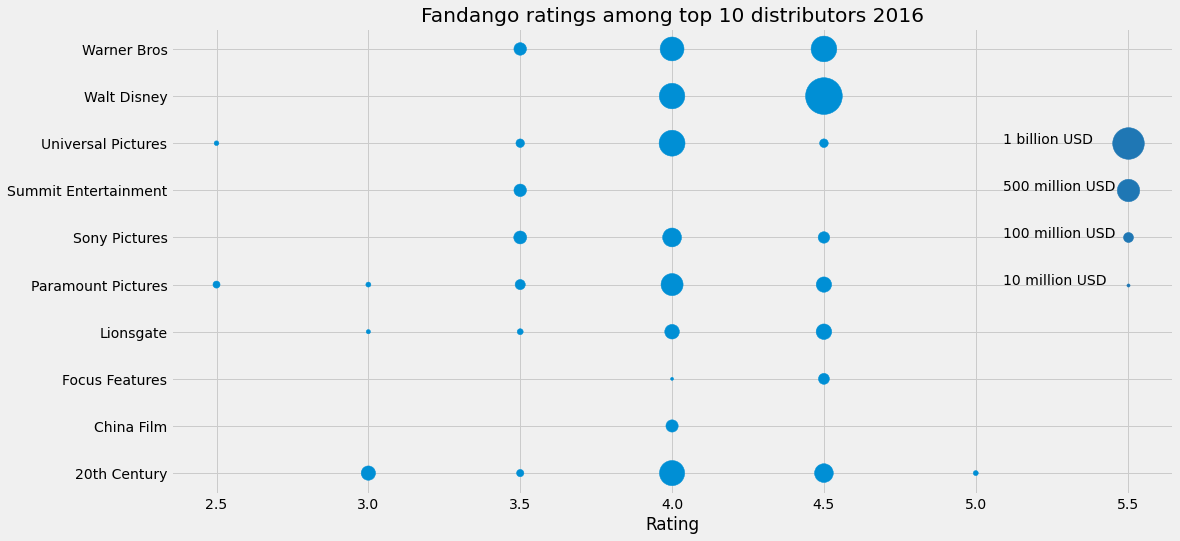

In [43]:
df_counts = m16_topdi.groupby(['distributor', 'fandango'])['low_end'].sum().reset_index(name='low_end')
fig, ax = plt.subplots(figsize=(16,8))

plt.scatter(data=df_counts, y='distributor', x='fandango', s='low_end')

plt.scatter(x=5.5, y=4, s=10, c='#1f77b4')
plt.scatter(x=5.5, y=5, s=100, c='#1f77b4')
plt.scatter(x=5.5, y=6, s=500, c='#1f77b4')
plt.scatter(x=5.5, y=7, s=1000, c='#1f77b4')

plt.text(5.09,4, '10 million USD')
plt.text(5.09,5, '100 million USD')
plt.text(5.09,6, '500 million USD')
plt.text(5.09,7, '1 billion USD')
plt.title('Fandango ratings among top 10 distributors 2016')
plt.xlabel('Rating')
plt.show()

**Observations:**
* We can observe a higher concentration of the capital in 2016 at the rating mark of 4 and 4.5 stars.
* Remembering the fact that the 2015 database is much smaller we can still conclude that in 2015 the capital was distributed in a more uniform way.

<a id='conclusion'></a>

# Conclusions:
[back to top](#index)

* Out of all the rating websites Rotten Tomatoes has the most uniform frequency distribution of ratings
* Fandango registered the biggest change in 2016 (compared to other platforms)
    * Their average rating in 2016 was lower than 2015
    * Their rating became more concentraded, especially around 4.0 and 4.5 mark
* In 2015 Movies distributed by small companies(not in top 10) had similar Fandango rating distributions to movies distributed by big companies
    * That has changed in 2016 - the average rating for a movie distributed by a small company dropped further down that an average rating for a movie distributed by a big company



